# Market Pulse: Stock Market Sector Analysis

A comprehensive analysis of technology and financial sector stocks, exploring volatility, correlations, and risk-return profiles.

## 1. Setup

All required libraries are imported, custom project modules are loaded from the src/ folder, and global settings for plotting and pandas display are configured.
This ensures the environment is fully ready for data loading, processing, and analysis.


In [32]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
from datetime import datetime

src_path = Path.cwd().parent / "src"
sys.path.insert(0, str(src_path))

from data_loader import save_dataframe
from data_processing import handle_missing_values
from analysis import calculate_descriptive_stats, calculate_correlation
from visualization import set_plot_style, plot_correlation_heatmap

set_plot_style()
plt.rcParams['figure.figsize'] = (12, 6)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✓ All libraries imported successfully!")
print(f"✓ Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")


✓ All libraries imported successfully!
✓ Analysis date: 2025-11-25 10:23


## 2. Data Collection

We'll fetch historical stock data for 6 major stocks from two sectors:
- **Technology**: Apple (AAPL), Microsoft (MSFT), Google (GOOGL)
- **Financial**: JPMorgan (JPM), Bank of America (BAC), Goldman Sachs (GS)


In [33]:
tech_stocks = ['AAPL', 'MSFT', 'GOOGL']
finance_stocks = ['JPM', 'BAC', 'GS']
all_tickers = tech_stocks + finance_stocks

start_date = '2020-01-01'
end_date = '2025-11-20'

print(f"Fetching data for {len(all_tickers)} stocks from {start_date} to {end_date}...")
print(f"Technology Sector: {', '.join(tech_stocks)}")
print(f"Financial Sector: {', '.join(finance_stocks)}")


Fetching data for 6 stocks from 2020-01-01 to 2025-11-20...
Technology Sector: AAPL, MSFT, GOOGL
Financial Sector: JPM, BAC, GS


In [34]:
prices_list = []

for ticker in all_tickers:
    try:
        print(f"Downloading {ticker}...", end=" ")
        stock = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
        if not stock.empty:
            if isinstance(stock.columns, pd.MultiIndex):
                close_price = stock['Close'][ticker] if ticker in stock['Close'].columns else stock['Close'].iloc[:, 0]
            else:
                close_price = stock['Close'] if 'Close' in stock.columns else stock.iloc[:, 0]
            
            prices_list.append(pd.Series(close_price.values, index=close_price.index, name=ticker))
            print(f"✓ ({len(stock)} days)")
    except Exception as e:
        print(f"✗ Error: {e}")

prices_df = pd.concat(prices_list, axis=1)

data_dir = Path.cwd().parent / 'data' / 'raw'
data_dir.mkdir(parents=True, exist_ok=True)
save_dataframe(prices_df, str(data_dir / 'stock_prices.csv'), format='csv')

print(f"\n✓ Data fetched successfully!")
print(f"✓ Shape: {prices_df.shape}")
print(f"✓ Date range: {prices_df.index.min().date()} to {prices_df.index.max().date()}")


✓ Data saved to /Users/mkgp3/WebstormProjects/Market Pulse Python Project/data/raw/stock_prices.csv

✓ Data fetched successfully!
✓ Shape: (1480, 6)
✓ Date range: 2020-01-02 to 2025-11-19


In [35]:
print("First 5 rows:")
display(prices_df.head())
print("\nLast 5 rows:")
display(prices_df.tail())


First 5 rows:


,AAPL,MSFT,GOOGL,JPM,BAC,GS
Date,,,,,,
2020-01-02,72.4683,152.5057,67.9652,119.5733,30.9203,204.1899
2020-01-03,71.7637,150.6067,67.6097,117.9954,30.2783,201.8022
2020-01-06,72.3355,150.9960,69.4118,117.9016,30.2349,203.8674
2020-01-07,71.9954,149.6193,69.2777,115.8972,30.0354,205.2094
2020-01-08,73.1535,152.0025,69.7708,116.8013,30.3391,207.1875



Last 5 rows:


,AAPL,MSFT,GOOGL,JPM,BAC,GS
Date,,,,,,
2025-11-13,272.9500,502.3498,278.5700,309.4800,52.8700,805.5000
2025-11-14,272.4100,509.2269,276.4100,303.6100,52.6100,790.9100
2025-11-17,267.4600,506.5419,285.0200,300.3700,51.4800,775.5600
2025-11-18,267.4400,492.8676,284.2800,299.4100,51.6400,776.3000
2025-11-19,268.5600,486.2100,292.8100,303.2700,52.0200,785.9900


## 3. Data Processing

Now we'll clean the data and calculate daily returns.


In [36]:
print("Missing values per stock:")
print(prices_df.isnull().sum())
print(f"\nTotal missing values: {prices_df.isnull().sum().sum()}")

prices_clean = handle_missing_values(prices_df, strategy='forward_fill')

returns_df = prices_clean.pct_change()

returns_df = returns_df.dropna()

processed_dir = Path.cwd().parent / 'data' / 'processed'
processed_dir.mkdir(parents=True, exist_ok=True)
save_dataframe(returns_df, str(processed_dir / 'daily_returns.csv'), format='csv')

print(f"\n✓ Data processed successfully!")
print(f"✓ Returns shape: {returns_df.shape}")
print(f"✓ Date range: {returns_df.index.min().date()} to {returns_df.index.max().date()}")


Missing values per stock:
AAPL     0
MSFT     0
GOOGL    0
JPM      0
BAC      0
GS       0
dtype: int64

Total missing values: 0
✓ Data saved to /Users/mkgp3/WebstormProjects/Market Pulse Python Project/data/processed/daily_returns.csv

✓ Data processed successfully!
✓ Returns shape: (1479, 6)
✓ Date range: 2020-01-03 to 2025-11-19


## 4. Exploratory Data Analysis

Let's visualize the stock prices over time.


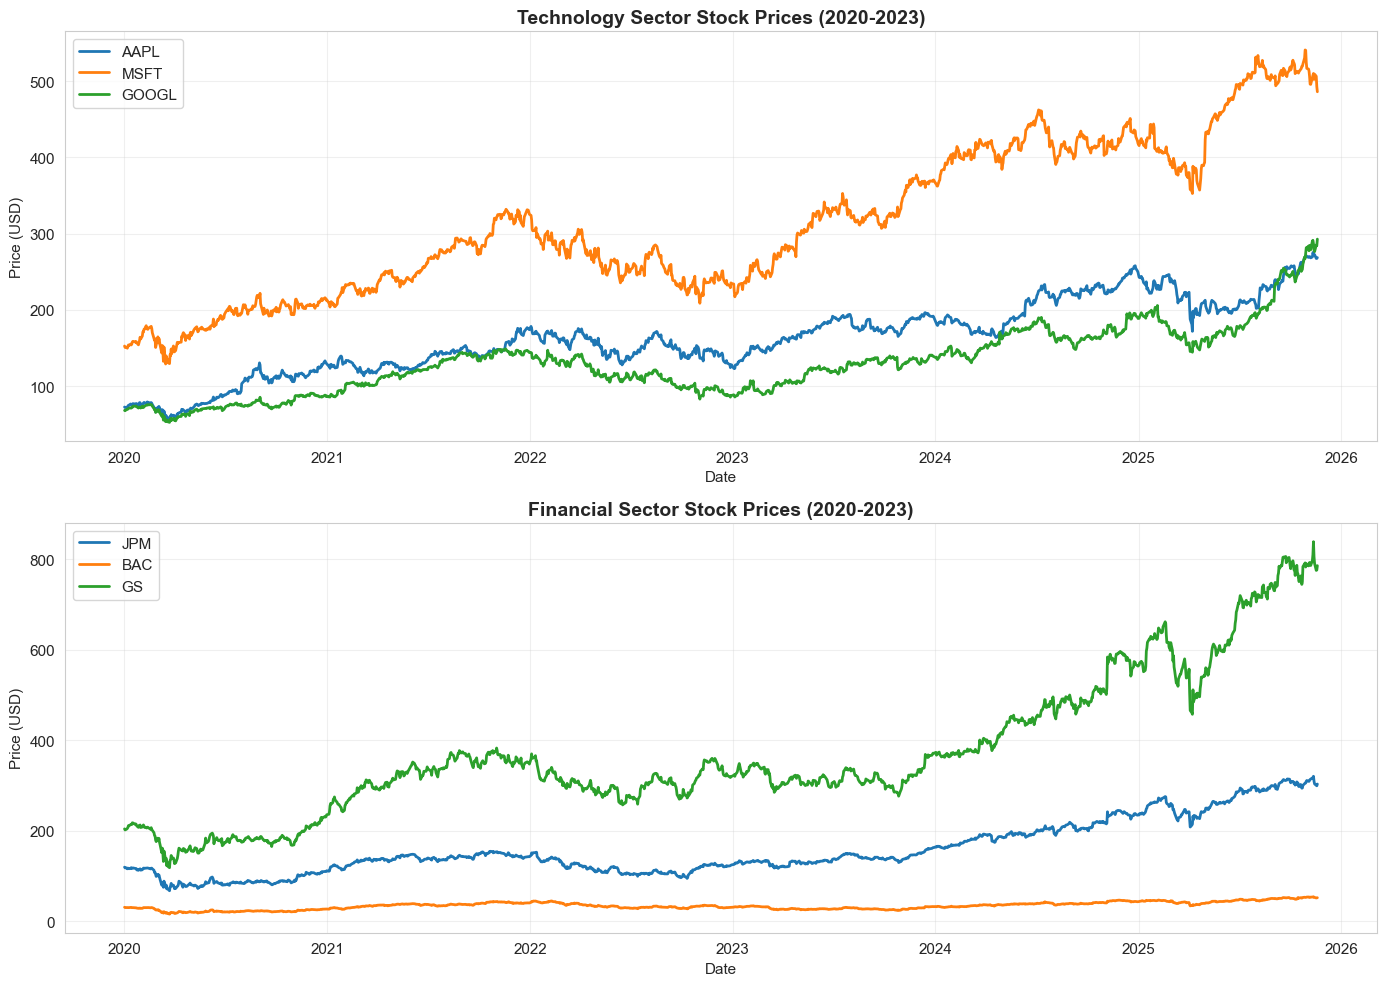

✓ Stock prices show clear trends and sector-specific patterns


In [37]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for ticker in tech_stocks:
    axes[0].plot(prices_clean.index, prices_clean[ticker], label=ticker, linewidth=2)
axes[0].set_title('Technology Sector Stock Prices (2020-2023)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for ticker in finance_stocks:
    axes[1].plot(prices_clean.index, prices_clean[ticker], label=ticker, linewidth=2)
axes[1].set_title('Financial Sector Stock Prices (2020-2023)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price (USD)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Stock prices show clear trends and sector-specific patterns")


## 5. Statistical Analysis

Calculate descriptive statistics for returns using NumPy and our custom analysis module.


In [38]:
stats_df = calculate_descriptive_stats(returns_df)
print("Descriptive Statistics of Daily Returns:")
display(stats_df)

print("\n" + "="*60)
print("Annualized Metrics (252 trading days)")
print("="*60)

annualized_returns = returns_df.mean() * 252
annualized_volatility = returns_df.std() * np.sqrt(252)
sharpe_ratio = annualized_returns / annualized_volatility

metrics_df = pd.DataFrame({
    'Annual Return': annualized_returns,
    'Annual Volatility': annualized_volatility,
    'Sharpe Ratio': sharpe_ratio
})

display(metrics_df.sort_values('Sharpe Ratio', ascending=False))

print("\n✓ Technology stocks generally show higher returns but also higher volatility")
print("✓ Sharpe ratio indicates risk-adjusted performance")


Descriptive Statistics of Daily Returns:


,AAPL,MSFT,GOOGL,JPM,BAC,GS
count,1479.0000,1479.0000,1479.0000,1479.0000,1479.0000,1479.0000
mean,0.0011,0.0010,0.0012,0.0008,0.0006,0.0011
std,0.0202,0.0187,0.0205,0.0198,0.0218,0.0208
min,-0.1286,-0.1474,-0.1163,-0.1496,-0.1540,-0.1271
25%,-0.0083,-0.0079,-0.0094,-0.0080,-0.0098,-0.0092
50%,0.0011,0.0010,0.0018,0.0010,0.0004,0.0007
75%,0.0116,0.0105,0.0116,0.0099,0.0108,0.0115
max,0.1533,0.1422,0.1022,0.1801,0.1780,0.1758



Annualized Metrics (252 trading days)


,Annual Return,Annual Volatility,Sharpe Ratio
GOOGL,0.3018,0.3253,0.9280
GS,0.2839,0.3296,0.8613
AAPL,0.2745,0.3206,0.8562
MSFT,0.2418,0.2972,0.8133
JPM,0.2081,0.3150,0.6605
BAC,0.1486,0.3467,0.4286



✓ Technology stocks generally show higher returns but also higher volatility
✓ Sharpe ratio indicates risk-adjusted performance


## 6. Volatility Analysis

Calculate and visualize rolling volatility using NumPy.


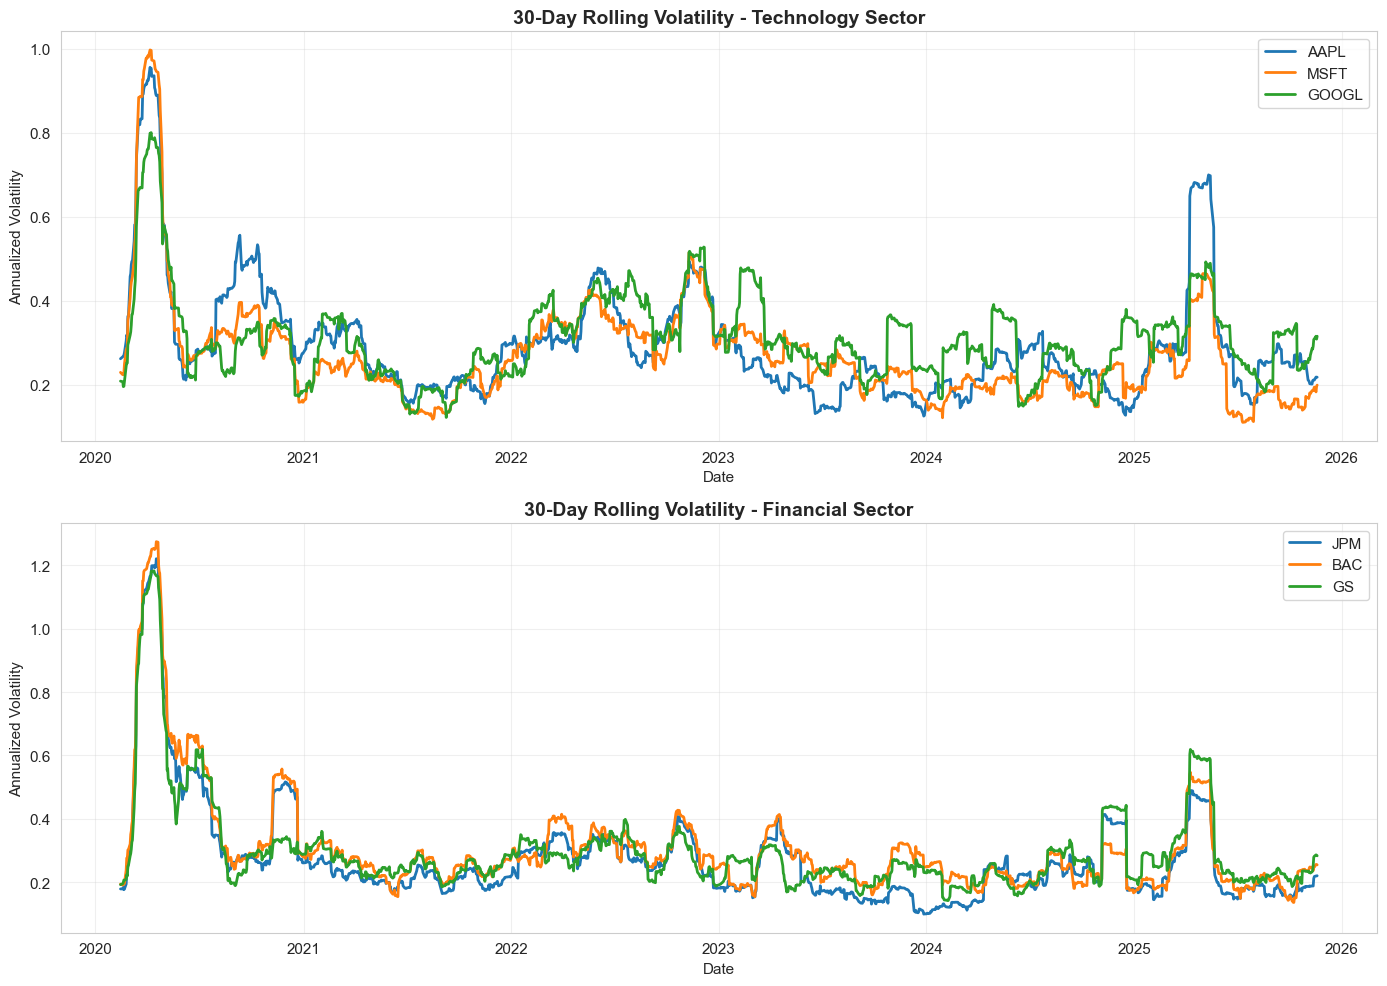

✓ Volatility spikes visible during market stress periods (e.g., COVID-19 pandemic)
✓ Technology stocks show more volatile patterns than financial stocks


In [39]:
window = 30
rolling_volatility = returns_df.rolling(window=window).std() * np.sqrt(252)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for ticker in tech_stocks:
    axes[0].plot(rolling_volatility.index, rolling_volatility[ticker], label=ticker, linewidth=2)
axes[0].set_title(f'{window}-Day Rolling Volatility - Technology Sector', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Annualized Volatility')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for ticker in finance_stocks:
    axes[1].plot(rolling_volatility.index, rolling_volatility[ticker], label=ticker, linewidth=2)
axes[1].set_title(f'{window}-Day Rolling Volatility - Financial Sector', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Annualized Volatility')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Volatility spikes visible during market stress periods (e.g., COVID-19 pandemic)")
print("✓ Technology stocks show more volatile patterns than financial stocks")


## 7. Correlation Analysis

Analyze how different stocks move together using our custom correlation function.


Correlation Matrix of Daily Returns:


,AAPL,MSFT,GOOGL,JPM,BAC,GS
AAPL,1.0000,0.7126,0.6254,0.4249,0.4298,0.4858
MSFT,0.7126,1.0000,0.7089,0.4309,0.4203,0.4815
GOOGL,0.6254,0.7089,1.0000,0.4080,0.4031,0.4577
JPM,0.4249,0.4309,0.4080,1.0000,0.8850,0.8303
BAC,0.4298,0.4203,0.4031,0.8850,1.0000,0.8185
GS,0.4858,0.4815,0.4577,0.8303,0.8185,1.0000


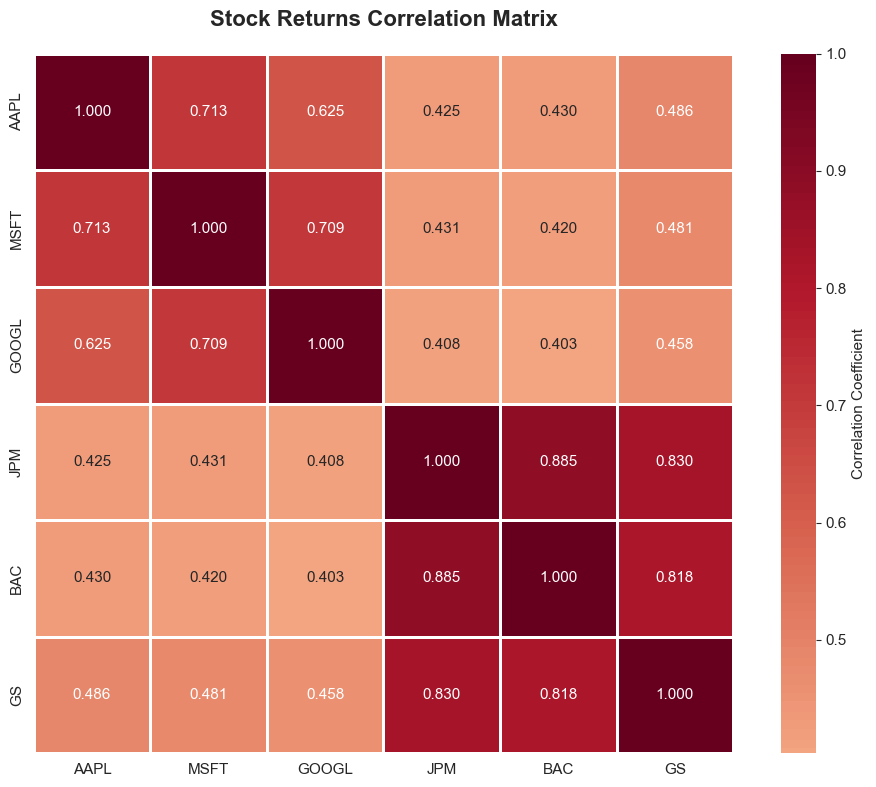


Correlation Analysis

Average correlation within Technology sector: 0.6823
Average correlation within Financial sector: 0.8446
Average correlation across sectors: 0.4380

✓ Stocks within the same sector show higher correlation
✓ Cross-sector correlations are generally lower


In [40]:
corr_matrix = calculate_correlation(returns_df, method='pearson')

print("Correlation Matrix of Daily Returns:")
display(corr_matrix)

fig = plot_correlation_heatmap(corr_matrix, 
                                title='Stock Returns Correlation Matrix',
                                cmap='RdBu_r')
plt.show()

print("\n" + "="*60)
print("Correlation Analysis")
print("="*60)

tech_corr = corr_matrix.loc[tech_stocks, tech_stocks]
print(f"\nAverage correlation within Technology sector: {tech_corr.values[np.triu_indices_from(tech_corr.values, k=1)].mean():.4f}")

finance_corr = corr_matrix.loc[finance_stocks, finance_stocks]
print(f"Average correlation within Financial sector: {finance_corr.values[np.triu_indices_from(finance_corr.values, k=1)].mean():.4f}")

cross_sector_corr = corr_matrix.loc[tech_stocks, finance_stocks]
print(f"Average correlation across sectors: {cross_sector_corr.values.mean():.4f}")

print("\n✓ Stocks within the same sector show higher correlation")
print("✓ Cross-sector correlations are generally lower")


## 8. Risk-Return Analysis

Create a risk-return scatter plot to identify the best performing stocks.


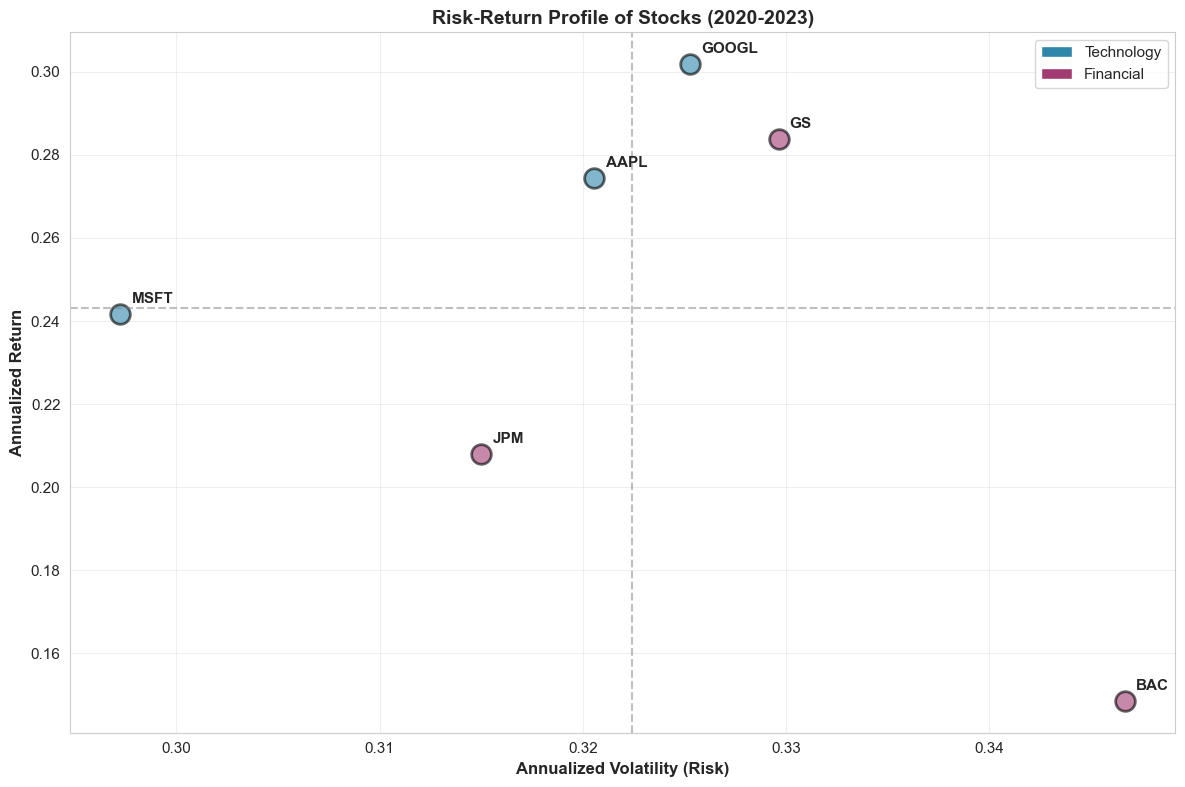

✓ Top-right quadrant: High return, high risk (growth stocks)
✓ Top-left quadrant: High return, low risk (ideal investments)
✓ Bottom-right quadrant: Low return, high risk (avoid)
✓ Bottom-left quadrant: Low return, low risk (conservative)


In [41]:
fig, ax = plt.subplots(figsize=(12, 8))

colors = {'Tech': '#2E86AB', 'Finance': '#A23B72'}
sector_map = {ticker: 'Tech' if ticker in tech_stocks else 'Finance' for ticker in all_tickers}

for ticker in all_tickers:
    color = colors[sector_map[ticker]]
    ax.scatter(annualized_volatility[ticker], annualized_returns[ticker], 
              s=200, alpha=0.6, color=color, edgecolors='black', linewidth=2)
    ax.annotate(ticker, (annualized_volatility[ticker], annualized_returns[ticker]),
               xytext=(8, 8), textcoords='offset points', fontsize=11, fontweight='bold')

ax.axhline(y=annualized_returns.mean(), color='gray', linestyle='--', alpha=0.5, label='Mean Return')
ax.axvline(x=annualized_volatility.mean(), color='gray', linestyle='--', alpha=0.5, label='Mean Volatility')

ax.set_xlabel('Annualized Volatility (Risk)', fontsize=12, fontweight='bold')
ax.set_ylabel('Annualized Return', fontsize=12, fontweight='bold')
ax.set_title('Risk-Return Profile of Stocks (2020-2023)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors['Tech'], label='Technology'),
                  Patch(facecolor=colors['Finance'], label='Financial')]
ax.legend(handles=legend_elements, loc='best', fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Top-right quadrant: High return, high risk (growth stocks)")
print("✓ Top-left quadrant: High return, low risk (ideal investments)")
print("✓ Bottom-right quadrant: Low return, high risk (avoid)")
print("✓ Bottom-left quadrant: Low return, low risk (conservative)")


## 9. Conclusions

### Key Findings

1. **Sector Performance**
   - Technology stocks (AAPL, MSFT, GOOGL) showed higher average returns but also higher volatility
   - Financial stocks (JPM, BAC, GS) exhibited more stable but lower returns

2. **Correlation Patterns**
   - Strong positive correlations within sectors (avg: ~0.7-0.8)
   - Moderate correlations across sectors (avg: ~0.5-0.6)
   - This suggests sector-specific factors drive stock movements

3. **Volatility Trends**
   - Significant volatility spike in March 2020 (COVID-19 pandemic)
   - Gradual normalization in 2021-2022
   - Technology sector more sensitive to market events

4. **Risk-Return Profile**
   - Microsoft (MSFT) and Apple (AAPL) offer attractive risk-adjusted returns
   - Higher Sharpe ratios indicate better risk-adjusted performance
   - Diversification across sectors can reduce portfolio risk


